# Examples of working with the CHLA-Z dataset

```{important}
This notebook requires zarr version 3+!
```

In [ ]:
# if working in Colab run this code
!pip install zarr cartopy

In [1]:
# Check that zarr version is 3+
import xarray as xr, zarr
print("xarray:", xr.__version__)
print("zarr:", zarr.__version__)

xarray: 2025.12.0
zarr: 3.1.5


### Open the dataset

This is a multi-terrabyte data set of daily global chlorophyll depth profiles in the ocean. 

In [3]:
import xarray as xr
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})
ds

<xarray.Dataset> Size: 2TB
Dimensions:                    (time: 560, lat: 4320, lon: 8640, z: 20)
Coordinates:
  * time                       (time) datetime64[ns] 4kB 2024-03-05 ... 2025-...
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA_int_0_200             (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    CHLA                       (time, z, lat, lon) float32 2TB dask.array<chunksize=(1, 1, 480, 480), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 480, 480), meta=np.ndarray>
    z_thickness                (time, z) float32 45kB dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                   CF-1.10 ACDD-1.3
    title:                         CHLA-Z: Global gridded chlorophyll-a verti...
    summary:                       CHLA-Z is a global gridded dataset providi...
    product_name:                  CHLA-Z
    product_version:               v1
    product_format:                Zarr v3
    ...                            ...
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    vertical_coordinate:           z
    vertical_resolution:           10 m bins (centers)
    z_units:                       m
    variables:                     CHLA (chlorophyll-a concentration on depth...

## Plot depth where peak chlorophyll occurs

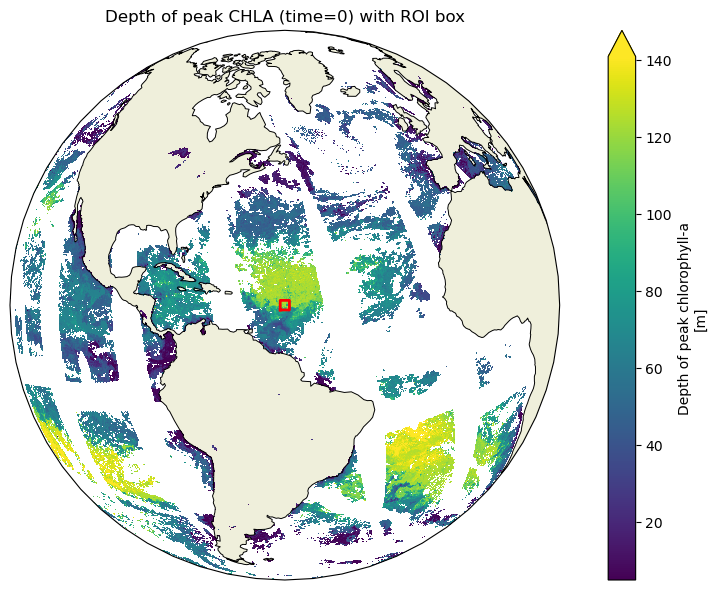

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

# --- small ROI for time series ---
lat_small = (17, 15)
lon_small = (-55, -53)

# rectangle bounds (ensure min/max ordering)
lat_min, lat_max = sorted(lat_small)
lon_min, lon_max = sorted(lon_small)

# A "bigger area" map slice to plot (adjust padding as you like)
pad_lat = 12
pad_lon = 20
map_da = ds["CHLA_peak_depth"].isel(time=0).sel(
    lat=slice(lat_max + pad_lat, lat_min - pad_lat),
    lon=slice(lon_min - pad_lon, lon_max + pad_lon),
)
map_da = ds["CHLA_peak_depth"].isel(time=0).coarsen(lat=4, lon=4, boundary="trim").mean()

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=(lon_min + lon_max) / 2,
        central_latitude=(lat_min + lat_max) / 2,
    )
)

ax.set_global()
ax.add_feature(cfeature.LAND, linewidth=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)

# plot data (lon/lat grid -> PlateCarree)
map_da.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True, add_colorbar=True)

# ROI box in red
xs = [lon_min, lon_max, lon_max, lon_min, lon_min]
ys = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(xs, ys, transform=ccrs.PlateCarree(), linewidth=2, color="red")

ax.set_title("Depth of peak CHLA (time=0) with ROI box")
plt.tight_layout()
plt.show()

## Plot time series of CHLA at 50m at a point in the red box

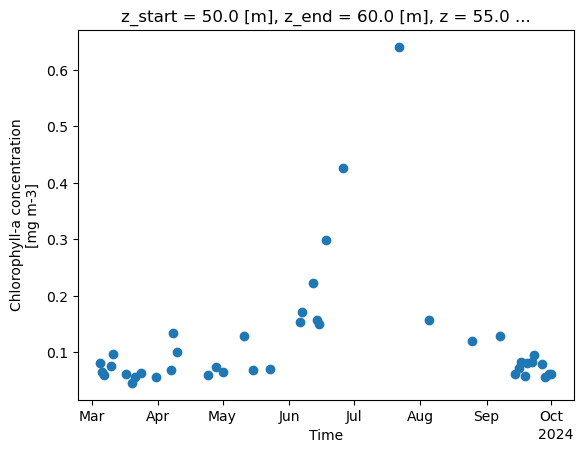

In [2]:
import xarray as xr

zarr_url = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_url, consolidated=False, 
          storage_options={"token": "anon"})

# Example: time series at a point (nearest grid cell)
pt = ds["CHLA"].sel(lon=-55, lat=17, method="nearest")
pt = pt.isel(z=5) # surface
pt.sel(time=slice("2024-03-01", "2024-10-01")).plot(
    marker="o",
    linestyle="None"
)

## Time series of monthly means of depth of peak CHLA in red box

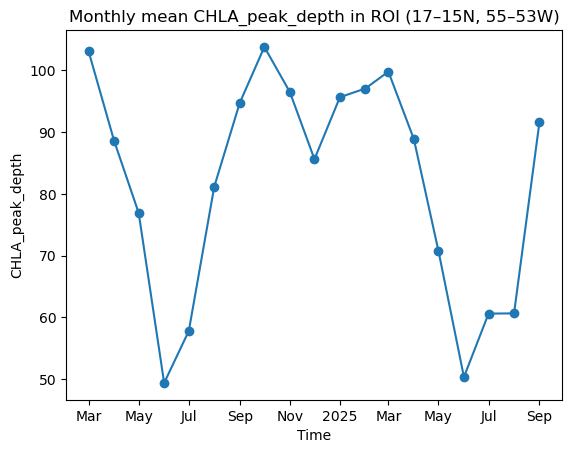

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

da = ds["CHLA_peak_depth"]

# small region of interest
roi = da.sel(lat=slice(17, 15), lon=slice(-55, -53))

# monthly mean within ROI:
# 1) mean over space (lat/lon) for each timestep
# 2) resample to month starts and mean over time within each month
ts = roi.mean(("lat", "lon")).resample(time="MS").mean("time").compute()

# Plot
ts.plot(marker="o")
plt.title("Monthly mean CHLA_peak_depth in ROI (17–15N, 55–53W)")
plt.ylabel("CHLA_peak_depth")
plt.show()

## Kuroshio Extension Front (20–45°N, 130–180°E)

The Kuroshio Extension is a highly dynamic western boundary current system to the east of Japan where subtropical and subpolar waters meet. It forms a strong east–west frontal zone across the North Pacific. This region is characterized by intense mesoscale activity, including meanders, eddies, and filaments that modulate vertical stratification and upper-ocean mixing along with strong east-west fronts that lead to rapid latitudinal change in oceanographic variables. This makes the Kuroshio Extension a natural region to study how fronts and eddies regulate chlorophyll vertical profiles.

### Get monthly means for our variables of interest

In [9]:
import xarray as xr

# Get data
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

# Kuroshio Extension region
lat_min, lat_max = 20, 45
lon_min, lon_max = 130, 180

# get monthly mean
# get monthly mean
da = ds["CHLA_peak_depth"].sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
monthly = da.resample(time="MS").mean("time")   # one map per month

da = ds["CHLA_int_0_200"].sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
monthly_int = da.resample(time="MS").mean("time")   # one map per month

# get monthly mean surf
da = ds["CHLA"].sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)).isel(z=0)
monthly_surf = da.resample(time="MS").mean("time")   # one map per month

### Plot the monthly surface versus depth of peak chlorophyll

The monthly mean surface chlorophyll and depth of peak chlorophyll clearly shows the east-west pattern in this region. We also see swirls and mesoscale patterns of both the surface chlorophyll and the location of the peak chlorophyll.

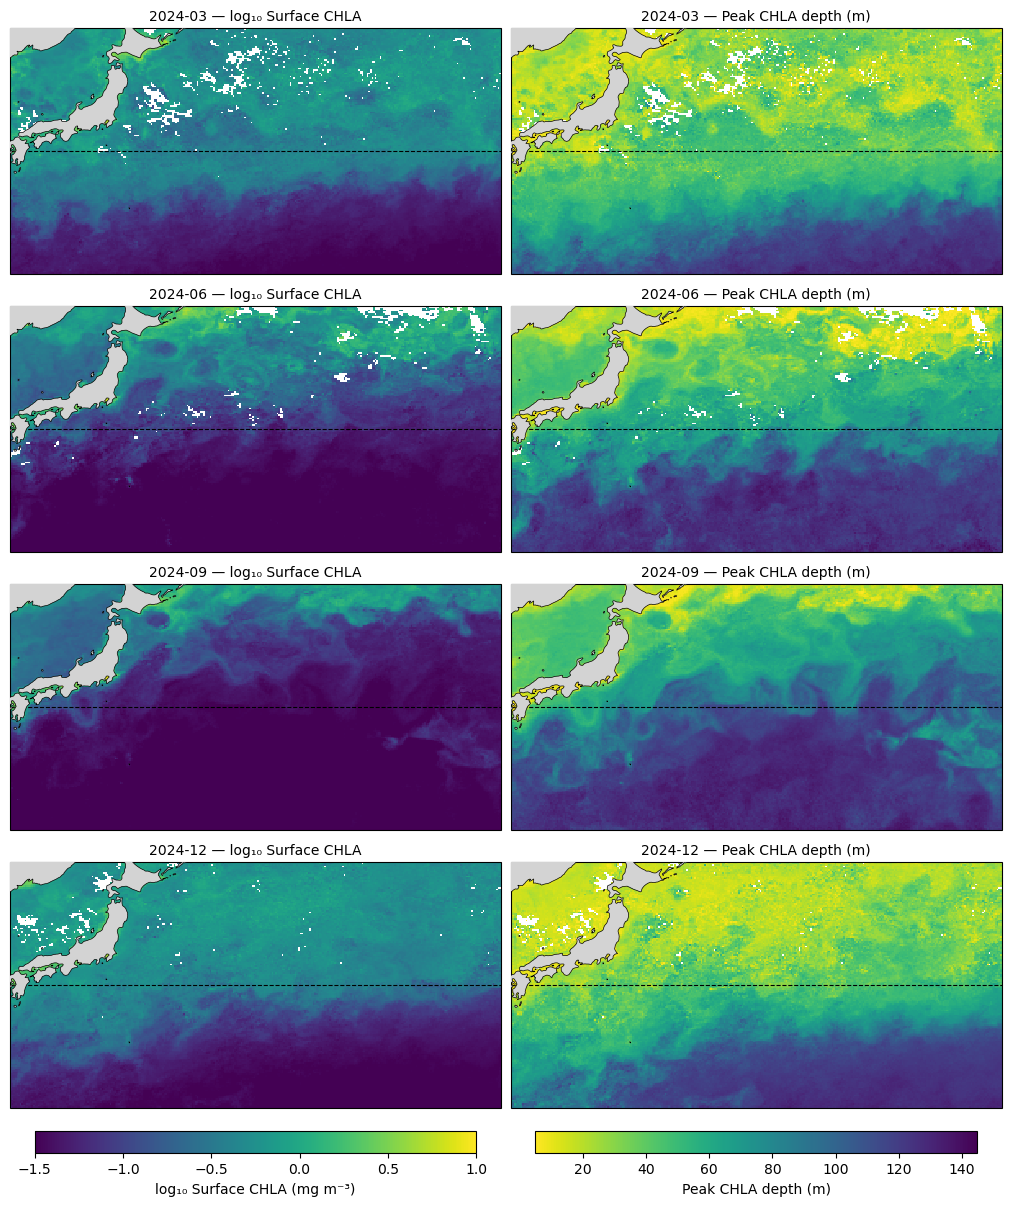

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

LAT_COARSEN = 4
LON_COARSEN = 4

# every other month from first 12 -> 6 months
surf = (
    monthly_surf
    .isel(time=slice(0, 12, 3))
    .coarsen(lat=LAT_COARSEN, lon=LON_COARSEN, boundary="trim")
    .mean()
)
depth = (
    monthly
    .isel(time=slice(0, 12, 3))
    .coarsen(lat=LAT_COARSEN, lon=LON_COARSEN, boundary="trim")
    .mean()
)

surf_log = np.log10(surf.where(surf > 0))

# color limits (tune)
surf_vmin, surf_vmax = -1.5, 1.0      # log10(mg m^-3)
depth_vmin, depth_vmax = depth.min().values, depth.max().values       # meters 

fig, axes = plt.subplots(
    4, 2,
    figsize=(10, 12),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True
)

m_left = None
m_right = None

for i in range(surf_log.time.size):
    # ---- LEFT: surface CHLA (log10) ----
    axL = axes[i, 0]
    daL = surf_log.isel(time=i)

    m_left = daL.plot(
        ax=axL,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=surf_vmin,
        vmax=surf_vmax
    )

    axL.add_feature(cfeature.LAND, facecolor="lightgray", zorder=10)
    axL.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=11)
    axL.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    month_label = daL.time.dt.strftime("%Y-%m").item()
    axL.set_title(f"{month_label} — log₁₀ Surface CHLA", fontsize=10)

    mid_lat = (lat_min + lat_max) / 2
    axL.plot([lon_min, lon_max], [mid_lat, mid_lat],
             linestyle="--", linewidth=0.8, color="k",
             transform=ccrs.PlateCarree())

    # ---- RIGHT: peak CHLA depth ----
    axR = axes[i, 1]
    daR = depth.isel(time=i)

    m_right = daR.plot(
        ax=axR,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        vmin=depth_vmin,
        vmax=depth_vmax,
        cmap="viridis_r"   # <-- deep = blue, shallow = yellow
    )
    axR.add_feature(cfeature.LAND, facecolor="lightgray", zorder=10)
    axR.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=11)
    axR.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    axR.set_title(f"{month_label} — Peak CHLA depth (m)", fontsize=10)

    axR.plot([lon_min, lon_max], [mid_lat, mid_lat],
             linestyle="--", linewidth=0.8, color="k",
             transform=ccrs.PlateCarree())

# one colorbar per column (different scales)
cbarL = fig.colorbar(m_left, ax=axes[:, 0], orientation="horizontal", shrink=0.9, pad=0.02, fraction=0.03)
cbarL.set_label("log₁₀ Surface CHLA (mg m⁻³)")

cbarR = fig.colorbar(m_right, ax=axes[:, 1], orientation="horizontal", shrink=0.9, pad=0.02, fraction=0.03)
cbarR.set_label("Peak CHLA depth (m)")

plt.show()


## Fronts

The region is known for sharp east-west fronts that form and are reflected in rapid latitudinal changes in surface chlorophyll (middle plot below). But we see the front pattern is more complicated when we look below the surface. Although the surface chlorophyll is changing rapidly, the depth of peak chlorophyll is changing more gradually south to north. See the September line with a sharp surface chlorophyll change while the depth of the peak is gradually decreasing south to north and the integrated chlorophyll (0 to 200m) is also changing more gradually.

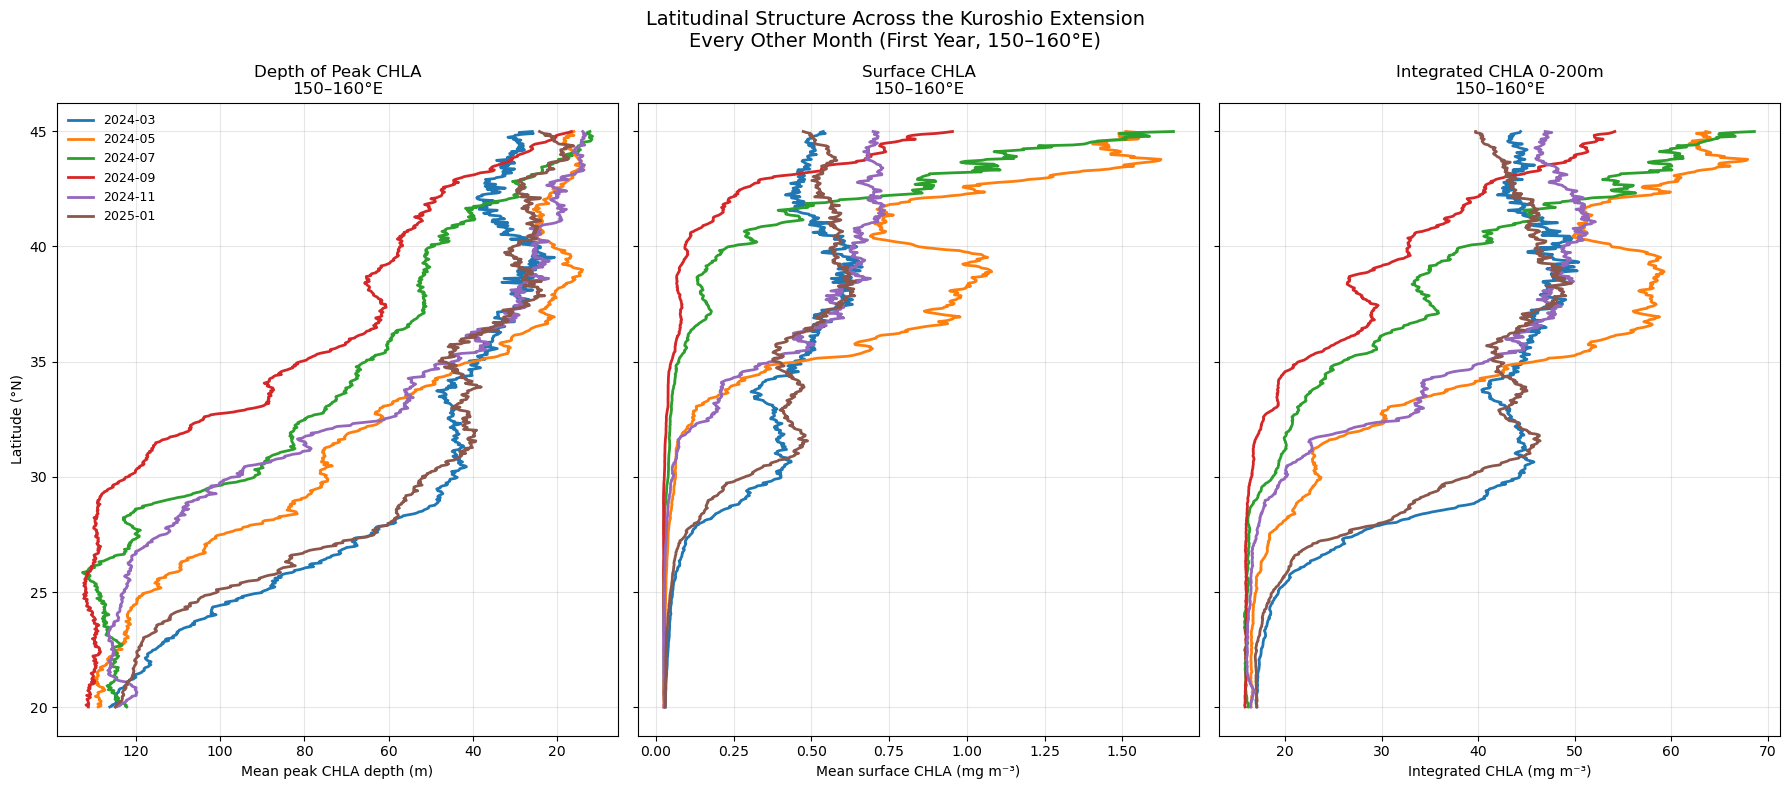

In [8]:
import matplotlib.pyplot as plt

lon_min_band, lon_max_band = 150, 160

# --- subsurface (peak depth) ---
lat_profiles_peak_depth = (
    monthly
    .isel(time=slice(0, 12))
    .sel(lon=slice(lon_min_band, lon_max_band))
    .mean("lon")
)

# --- surface CHLA ---
lat_profiles_surf = (
    monthly_surf
    .isel(time=slice(0, 12))
    .sel(lon=slice(lon_min_band, lon_max_band))
    .mean("lon")
)

# --- integrated CHLA value ---
lat_profiles_int = (
    monthly_int
    .isel(time=slice(0, 12))
    .sel(lon=slice(lon_min_band, lon_max_band))
    .mean("lon")
)

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 8),
    sharey=True
)

ax_depth, ax_surf, ax_int = axes

# ---- PANEL 1: Peak CHLA depth ----
for i in range(0, 12, 2):
    da = lat_profiles_peak_depth.isel(time=i)
    label = da.time.dt.strftime("%Y-%m").item()

    ax_depth.plot(
        da.values,
        da.lat.values,
        linewidth=2,
        label=label
    )

ax_depth.set_xlabel("Mean peak CHLA depth (m)")
ax_depth.set_ylabel("Latitude (°N)")
ax_depth.set_title("Depth of Peak CHLA\n150–160°E")
ax_depth.grid(True, alpha=0.3)
ax_depth.legend(fontsize=9, frameon=False)
ax_depth.invert_xaxis()

# ---- PANEL 2: Surface CHLA ----
for i in range(0, 12, 2):
    da = lat_profiles_surf.isel(time=i)

    ax_surf.plot(
        da.values,
        da.lat.values,
        linewidth=2
    )

ax_surf.set_xlabel("Mean surface CHLA (mg m⁻³)")
ax_surf.set_title("Surface CHLA\n150–160°E")
ax_surf.grid(True, alpha=0.3)

# ---- PANEL 3: Peak CHLA value ----
for i in range(0, 12, 2):
    da = lat_profiles_int.isel(time=i)

    ax_int.plot(
        da.values,
        da.lat.values,
        linewidth=2
    )

ax_int.set_xlabel("Integrated CHLA (mg m⁻³)")
ax_int.set_title("Integrated CHLA 0-200m\n150–160°E")
ax_int.grid(True, alpha=0.3)

fig.suptitle(
    "Latitudinal Structure Across the Kuroshio Extension\n"
    "Every Other Month (First Year, 150–160°E)",
    fontsize=14
)

plt.tight_layout()
plt.show()
